# Lab Project Part 2 CNNs for Image Classification


Group M05 code

------------------------------

## Setup

### Imports, mounting storage, preferences

In [ ]:
# Link to Google Drive to persist models
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PROJDIR = "/content/drive/My Drive/Data/cv1"
!ls "/content/drive/My Drive/Data/cv1"

convnet_basic.pt  convnet_best.pt  ray_results	twolayernet_basic.pt


In [ ]:
# Install ray tune
!pip install -U ray

In [ ]:
#####################################################
# referenced codes: https://pytorch.org/tutorials/
# referenced codes: http://cs231n.stanford.edu/
# referenced codes: https://cs.stanford.edu/~acoates/stl10/
######################################################
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset
import os
import pickle
from PIL import Image

In [ ]:
# Fancy graphics
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set sensible defaults
import seaborn as sns
sns.set()
sns.set_style("ticks")
sns.set_context('paper')

In [ ]:
# Enable CUDA GPU support, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Defining re-usable functions for training, validating, visualising, etc.

In [ ]:
def valid(net, testloader, verbose=True):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

    return correct / total

In [ ]:
def valid_class(net,testloader,classes):
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(len(classes)):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
# Visualiser from https://pytorch.org/tutorials/

def visualize_model(model, dataloader, classes, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j].item()]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

In [ ]:
def train(net, trainloader, optimiser=None, epochs=1):
    print(f"Training {type(net)} on {device} for {epochs} epochs on {len(trainloader)} minibatches...\n\n")

    ###################### Define Loss function and optimizer
    # https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

    # Optimizer defined (if not procided)
    if optimiser is not None:
        optimizer = optimiser
    else:
        optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.8)

    # Cross Entropy loss function
    criterion = nn.CrossEntropyLoss()
    
    ############################### Training
    # Create lists for tracking loss and accuracy
    running_losses, epoch_losses, train_accs = [], [], []

    for epoch in range(epochs):  # loop over the dataset multiple times 
        running_loss = 0.0

        # Get a minibatch of data
        for i, (inputs, labels) in enumerate(trainloader, 0):

            # Move to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            # Reset gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Update and log training losses
            running_loss += loss.item()
            running_losses.append(running_loss)

            # Backpropagation and weight updating
            loss.backward()
            optimizer.step()

            # Show statistics
            if i% (len(trainloader)//10) == 0:
                print(f"{epoch+1}|{i}/{len(trainloader)}\tRunning loss: {running_loss}")
                running_loss = 0.0
            
        # Calculate avg loss over epoch
        epoch_losses.append(running_loss / len(trainloader.dataset))
        print()

    print('Training complete')

    return running_losses, epoch_losses #, train_accs

## Session 1: Image Classifiation on CIFAR 10

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


####  *` Q2.1: test dataloader and show the images of each class  of CIFAR10`*  

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

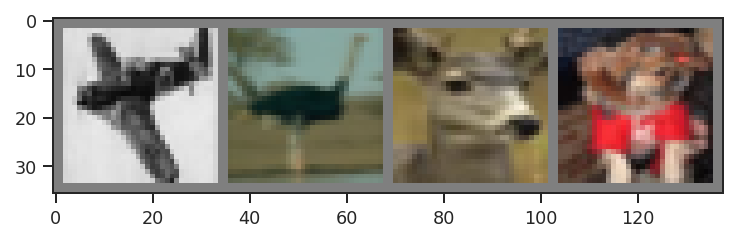

plane  bird  deer   dog


In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

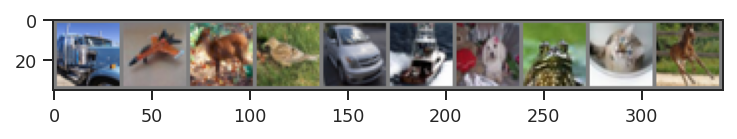

['truck', 'plane', 'deer', 'bird', 'car', 'ship', 'dog', 'frog', 'cat', 'horse']


In [ ]:
# This code ensures we get at least one example of each class

sample_images = []
outstanding_labels = [c for c in classes]
labels_ordered = []

for step, (images, labels) in enumerate(trainloader):
    if len(outstanding_labels) == 0 or step > 100:
        break
    for image, label in zip(images, labels):
        _label = classes[label.item()]
        if _label in outstanding_labels:
            sample_images.append(image)
            outstanding_labels.remove(_label)
            labels_ordered.append(_label)

imshow(torchvision.utils.make_grid(sample_images, nrow=10))
print(labels_ordered)

####  *` Q2.2: Architecture understanding. Implement architecture of TwolayerNet and ConvNet.`*  

In [ ]:
class TwolayerNet(nn.Module):
    # ordinary two-layer network with fully connected layers and ReLu
    # assign layer objects to class attributes
    # nn.init package contains convenient initialization methods
    # http://pytorch.org/docs/master/nn.html#torch-nn-init
    def __init__(self, input_size=3*32*32, hidden_size=300, num_classes=10):
        '''
        :param input_size: 3*32*32
        :param hidden_size: 
        :param num_classes: 
        '''
        super(TwolayerNet, self).__init__()
        
        # Define two layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

        
    def forward(self,x):
        # flatten
        x = x.view(x.shape[0], -1)
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores

# Verify the architecture and parameters for the Class using torchsummary
demo_net = TwolayerNet().to(device)
summary(demo_net, (3, 32, 32))
del demo_net

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 300]         921,900
            Linear-2                   [-1, 10]           3,010
Total params: 924,910
Trainable params: 924,910
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 3.53
Estimated Total Size (MB): 3.54
----------------------------------------------------------------


In [ ]:
class ConvNet(nn.Module):
    # Convolutional Network utilizing the structure of LeNet-5
    # Complete the code using LeNet-5
    # reference: https://ieeexplore.ieee.org/document/726791
    # reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network
    def __init__(self):
        super(ConvNet, self).__init__()

        # Define 5x5 convolution layers and 2x2 max pooling layers
        self.c1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.c3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define fully-connected layers
        self.c5 = nn.Linear(16*5*5, 120)
        self.f6 = nn.Linear(120, 84)
        self.o = nn.Linear(84, 10)
        
    def forward(self, x):
        # I think original LeNet-5 used sigmoid, but in 2020 we know ReLU is better here.

        # Apply activation between conv and pooling layers (c1-s2-c3-s4)
        x = self.s2(torch.tanh(self.c1(x)))
        x = self.s4(torch.tanh(self.c3(x)))

        # Flatten out the shape of x
        x = x.view(-1, 400)

        # Apply activation through fully-connected layers (c5-f6-o)
        x = torch.tanh(self.c5(x))
        x = torch.tanh(self.f6(x))
        x = F.log_softmax(self.o(x), dim=-1)
        
        return x

# Verify the architecture and parameters for the Class using torchsummary
demo_net = ConvNet().to(device)
summary(demo_net, (3, 32, 32))
del demo_net

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------



LeNet-5 architecture

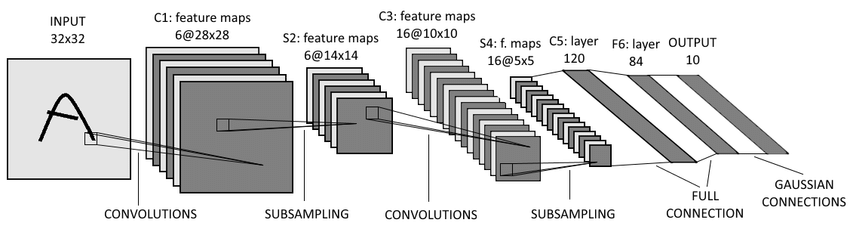

####  Train Two-layer Net

In [ ]:
# Initialise 2-layer net
twolayernet = TwolayerNet()

# Enable GPU support (if available)
twolayernet = twolayernet.to(device)

# Train 2L net
running_losses_2l, epoch_losses_2l = train(twolayernet, trainloader, epochs=40)

# Save the resulting model's state for later use
# https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(twolayernet.state_dict(), f"{PROJDIR}/twolayernet_basic.pt")

# (Optionally load the model from a previous run so you don't need to re-train)
# loadednet = TwolayerNet()
# twolayernet.load_state_dict(torch.load(f"{PROJDIR}/twolayernet_basic.pt"))
# twolayernet = twolayernet.to(device)

Training <class '__main__.TwolayerNet'> on cuda:0 for 40 epochs on 12500 minibatches...


1|0/12500	Running loss: 2.3610222339630127
1|1250/12500	Running loss: 2431.100662112236
1|2500/12500	Running loss: 2324.5718743801117
1|3750/12500	Running loss: 2343.1401765942574
1|5000/12500	Running loss: 2293.937587559223
1|6250/12500	Running loss: 2282.8753212690353
1|7500/12500	Running loss: 2330.6439817771316
1|8750/12500	Running loss: 2314.4363752305508
1|10000/12500	Running loss: 2294.06366661191
1|11250/12500	Running loss: 2291.363684386015

2|0/12500	Running loss: 2.775860548019409
2|1250/12500	Running loss: 2254.5007757246494
2|2500/12500	Running loss: 2257.9705182611942
2|3750/12500	Running loss: 2204.9355365633965
2|5000/12500	Running loss: 2240.183506771922
2|6250/12500	Running loss: 2289.271223627031
2|7500/12500	Running loss: 2282.20240662992
2|8750/12500	Running loss: 2239.194770157337
2|10000/12500	Running loss: 2229.807385519147
2|11250/12500	Running loss: 2271.551315665245

3|0

#### Train ConvNet

In [ ]:
# Initialise LeNet-5 net
convnet = ConvNet()

# Enable GPU support (if available)
convnet = convnet.to(device)

# Train network
running_losses_conv, epoch_losses_conv = train(convnet, trainloader, epochs=40)

# Save the resulting model's state for later use
# https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(convnet.state_dict(), f"{PROJDIR}/convnet_basic.pt")

# (Optionally load the model from a previous run so you don't need to re-train)
# convnet = ConvNet()
# convnet.load_state_dict(torch.load(f"{PROJDIR}/convnet_basic.pt"))
# convnet = convnet.to(device)

Training <class '__main__.ConvNet'> on cuda:0 for 40 epochs on 12500 minibatches...


1|0/12500	Running loss: 2.2873520851135254
1|1250/12500	Running loss: 2419.1333594322205
1|2500/12500	Running loss: 2128.8039909005165
1|3750/12500	Running loss: 2054.7316457033157
1|5000/12500	Running loss: 2003.8618477582932
1|6250/12500	Running loss: 1920.265795469284
1|7500/12500	Running loss: 1828.17956122756
1|8750/12500	Running loss: 1848.8693043887615
1|10000/12500	Running loss: 1803.460022419691
1|11250/12500	Running loss: 1784.2843100726604

2|0/12500	Running loss: 1.082586646080017
2|1250/12500	Running loss: 1690.6451381742954
2|2500/12500	Running loss: 1731.4401735067368
2|3750/12500	Running loss: 1717.4758918583393
2|5000/12500	Running loss: 1682.9635401368141
2|6250/12500	Running loss: 1658.8002568781376
2|7500/12500	Running loss: 1656.7614069133997
2|8750/12500	Running loss: 1690.9818420559168
2|10000/12500	Running loss: 1645.3784946203232
2|11250/12500	Running loss: 1620.7191123515368


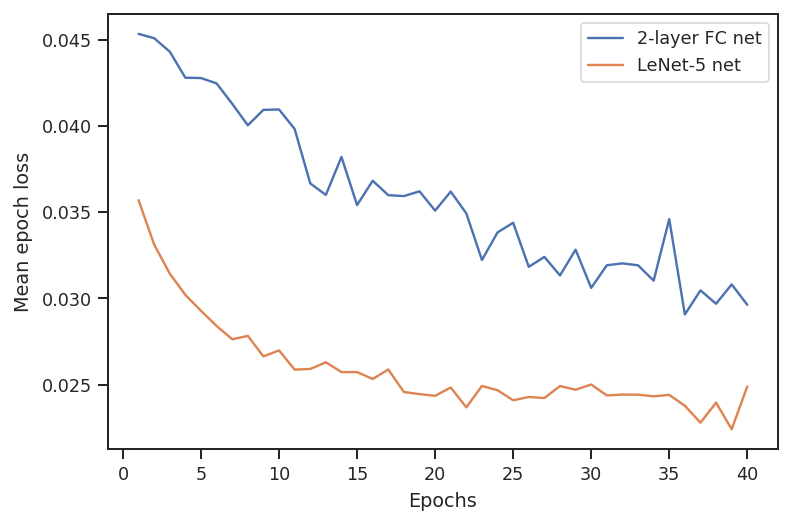

In [ ]:
# Show the learning curves (3-pts)

plt.plot(range(1, len(epoch_losses_2l) + 1), epoch_losses_2l, label='2-layer FC net')
plt.plot(range(1, len(epoch_losses_conv) + 1), epoch_losses_conv, label='LeNet-5 net')
plt.xlabel('Epochs')
plt.ylabel('Mean epoch loss')
plt.legend()

In [ ]:
# Quantify accuracy of networks on test set

print("TwoLayernet:")
print("Accuracy:", valid(twolayernet, testloader))
valid_class(twolayernet, testloader, classes)

print("LeNet-5:")
print("Accuracy:", valid(convnet, testloader))
valid_class(convnet, testloader, classes)

TwoLayernet:
Accuracy: 0.4507
Accuracy of plane : 57 %
Accuracy of   car : 60 %
Accuracy of  bird : 41 %
Accuracy of   cat : 28 %
Accuracy of  deer : 37 %
Accuracy of   dog : 33 %
Accuracy of  frog : 44 %
Accuracy of horse : 46 %
Accuracy of  ship : 46 %
Accuracy of truck : 54 %
LeNet-5:
Accuracy: 0.5272
Accuracy of plane : 65 %
Accuracy of   car : 63 %
Accuracy of  bird : 35 %
Accuracy of   cat : 39 %
Accuracy of  deer : 55 %
Accuracy of   dog : 34 %
Accuracy of  frog : 58 %
Accuracy of horse : 52 %
Accuracy of  ship : 59 %
Accuracy of truck : 63 %


#### *` Complement  CIFAR10_loader()`*

In above section, we use the CIFAR10 dataset class from torchvision.utils provided by PyTorch. Whereas in most cases, you need to prepare the dataset yourself. One of the ways is to create a dataset class yourself and then use the DataLoader to make it iterable. After preparing the training and testing data, you also need to define the transform function for data augmentation and optimizer for parameter updating.

In [ ]:
###  suggested reference: https://pytorch.org/tutorials/
# recipes/recipes/custom_dataset_transforms_loader.html?highlight=dataloader
# functions to show an image

class CIFAR10_loader(Dataset):
    def __init__(self, root, train=True, transform=None):
        
        # Initialise parent
        # super(CIFAR10_loader, self).__init__(root, train=train, transform=transform)

        # Set attributes
        self.transform = transform
        self.root = root
        self.data = []
        self.labels = []

        # Set train or test mode
        self.train = train

        # Read the data batches
        if train:
            batchlist = ['data_batch_1',
                         'data_batch_2',
                         'data_batch_3',
                         'data_batch_4',
                         'data_batch_5']
        else:
            batchlist = ['test_batch']

        for fname in batchlist:
            fpath = os.path.join(self.root, 'cifar-10-batches-py', fname)
            # Read the pickle file and save contents to data and labels
            with open(fpath, 'rb') as file:
                contents = pickle.load(file, encoding='latin1')
                self.data.append(contents['data'])
                self.labels.extend(contents['labels'])

        # Reshape the data into -1 x 3 x 32 x 32 array
        self.data = np.vstack(self.data)
        self.data = self.data.reshape(-1, 3, 32, 32)

        # Re-order array to height, width, channel 
        self.data = self.data.transpose(0, 2, 3, 1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):

        # Get image data and label at the given index
        img = self.data[index]
        label = self.labels[index]
        # Transform to Image object for compatibility
        img = Image.fromarray(img)

        # Apply the defined transformation to image
        img = self.transform(img) if self.transform is not None else img

        return img, target

#### *` Complement Transform function and Optimizer`*

In [ ]:
def normalise_tensor(image):
    """ First transforms image to tensor, then normalises
    """
    # Convert to pytorch tensor
    tensor = F.to_tensor(image)

    # Normalise image tensor to means and stds of 0.5 (using L2 norm)
    # Calculate denomenator
    denom = tensor.norm((0.5, 0.5, 0.5), keepdim=True).clamp_min_(1e-12).expand_as(tensor)
    result = torch.div(tensor, denom)

    return result

In [ ]:
my_trainset = CIFAR10_loader(root='./data', train=True, transform=normalise_tensor)
my_trainloader = torch.utils.data.DataLoader(my_trainset, batch_size=4, shuffle=True, num_workers=2)

my_testset = CIFAR10_loader(root='./data', train=False, transform=normalise_tensor)
my_testloader = torch.utils.data.DataLoader(my_testset, batch_size=4, shuffle=False, num_workers=2)

#### *` Train the ConvNet with CIFAR10_loader, transform and optimizer you implemented and compare the results`*

In [ ]:
# Initialise LeNet-5 net
convnet = ConvNet()

# Enable GPU support (if available)
convnet = convnet.to(device)

# Define custom optimiser TODO
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.8)

# Train network (re-using our training function from way above)
running_losses_conv2, epoch_losses_conv2 = train(convnet, trainloader, optimiser=optimizer, epochs=40)

Training <class '__main__.ConvNet'> on cuda:0 for 40 epochs on 12500 minibatches...


1|0/12500	Running loss: 2.2958812713623047
1|1250/12500	Running loss: 2500.6120710372925
1|2500/12500	Running loss: 2118.4451593458652
1|3750/12500	Running loss: 2053.2213325202465
1|5000/12500	Running loss: 1950.9074392020702
1|6250/12500	Running loss: 1921.7268627285957
1|7500/12500	Running loss: 1884.4194627702236
1|8750/12500	Running loss: 1842.70053383708
1|10000/12500	Running loss: 1794.0419919490814
1|11250/12500	Running loss: 1778.16201120615

2|0/12500	Running loss: 1.4422465562820435
2|1250/12500	Running loss: 1725.5517544150352
2|2500/12500	Running loss: 1671.120018094778
2|3750/12500	Running loss: 1670.4777095019817
2|5000/12500	Running loss: 1657.6235674023628
2|6250/12500	Running loss: 1680.954294204712
2|7500/12500	Running loss: 1634.8950923532248
2|8750/12500	Running loss: 1648.8962879627943
2|10000/12500	Running loss: 1624.5885468572378
2|11250/12500	Running loss: 1645.8239579349756



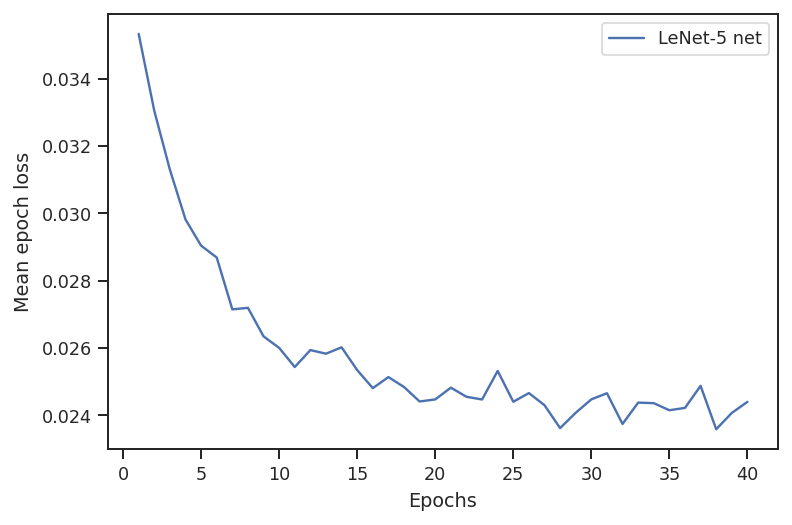

In [ ]:
# Show the learning curve
plt.plot(range(1, len(epoch_losses_conv2) + 1), epoch_losses_conv2, label='LeNet-5 net')
plt.xlabel('Epochs')
plt.ylabel('Mean epoch loss')
plt.legend()

In [ ]:
# Quantify accuracy of network on test set
print("LeNet-5 (custom):")
print("Accuracy:", valid(convnet, testloader))
valid_class(convnet, testloader, classes)

LeNet-5 (custom):
Accuracy: 0.54
Accuracy of plane : 59 %
Accuracy of   car : 66 %
Accuracy of  bird : 29 %
Accuracy of   cat : 29 %
Accuracy of  deer : 53 %
Accuracy of   dog : 53 %
Accuracy of  frog : 66 %
Accuracy of horse : 53 %
Accuracy of  ship : 68 %
Accuracy of truck : 59 %


#### *`Q2.4Play with convNet and TwolayerNet, set up the hyperparameters and reach the accuracy as high as you can`*

"1.Play with ConvNet and TwolayerNet yourself, set up the hyperparameters and reach the accuracy as high as you can. You can modify the train, Dataloader, transform and Optimizer function as you like. You can also modify the architecture of these two Nets. Show the final results and described what you’ve done for improving the results.

2.Show the results, describe the influence of hyperparameters among TwolayerNet and ConvNet and explain why.

Hint: You can adjust the following parameters and other parameters not listed here as you like:
Learning rate, Batch size, Number of epochs, optimizer, transform function, Weight decay etc."


In [ ]:
# Tuning with Ray Tune : https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html

from ray import tune
from ray.tune import CLIReporter, JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler
from torch.utils.data import random_split

# Data loader and transform wrapper
def load_cifar10_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset

# Training wrapper function
def train_cifar10(config, checkpoint_dir=f"{PROJDIR}/raytune", data_dir="./data"):
    net = TwolayerNet(hidden_size=config['hidden_nodes'])  # ----------------------------------------------------------------- Change this for net
    net.to(device)

    # Set Loss function and Optimiser (with variable learning rate)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)
    
    # Load prepared data
    trainset, testset = load_cifar10_data(data_dir=data_dir)

    # Split train into train and val sets
    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    # Make dataloaders
    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=4)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=4)

    # Load network and optimiser state from checkpoint (if applicable)
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    # Loop over dataset `epochs` times
    for epoch in range(config['epochs']):
        running_loss = 0.0
        epoch_steps = 0

        # Standard training step
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / epoch_steps))
                running_loss = 0.0
        
        # Standard validation step
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        # Save the states of network and optimiser to checkpoint (if applicable)
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        # Notify Ray Tune of the results            
        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)

    print("\n\nTraining complete")


In [ ]:
from functools import partial

# Configuring the hyperparameter search space
hypers = {
    "lr": tune.loguniform(1e-4, 1e-2),
    "batch_size": tune.choice([2, 4, 6]),
    'epochs': tune.choice([5, 10, 15, 20]),
    'hidden_nodes': tune.randint(100, 500)
}


# Configure and run hyperparameter search using Ray Tune
result = tune.run(
    partial(train_cifar10, data_dir="./data"),
    name='twolayer',
    resources_per_trial={"cpu": 1, "gpu": 1},
    time_budget_s=12*60*60, # Limit to 12 hours
    local_dir=f"{PROJDIR}/ray_results",
    log_to_file=True,
    config=hypers,
    num_samples=1,  # Number of times to sample from the hyperparameter space. 
    scheduler=ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=30,
        grace_period=1,
        reduction_factor=2),
    progress_reporter=CLIReporter(
        # overwrite=False,
        parameter_columns=[k for k in hypers.keys()],
        metric_columns=["loss", "accuracy", "training_iteration"])
    )

In [ ]:
# Find the best results for a network

best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result["accuracy"]))

best_trained_model = TwolayerNet(hidden_size=best_trial.config['hidden_nodes'])
best_trained_model.to(device)

best_checkpoint_dir = best_trial.checkpoint.value
model_state, optimizer_state = torch.load(os.path.join(
    best_checkpoint_dir, "checkpoint"))
best_trained_model.load_state_dict(model_state)

test_acc = valid(best_trained_model, testloader)
print("Best trial test set accuracy: {}".format(test_acc))

#### *` test the accuracy of ConvNet `*

In [ ]:
# We'll just hardcode the best config so we don't have to re-run Raytune
# batch size = 4
# epochs = 15
# learning rate = 0.0007706513633905408

# Set up
convnet = ConvNet()
convnet.to(device)
optimizer = optim.SGD(convnet.parameters(), lr=0.0008, momentum=0.9)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# Training 
running_losses_conv, epoch_losses_conv = train(convnet, trainloader, epochs=15)

Training <class '__main__.ConvNet'> on cuda:0 for 15 epochs on 12500 minibatches...


1|0/12500	Running loss: 2.333108425140381
1|1250/12500	Running loss: 2446.0735681056976
1|2500/12500	Running loss: 2167.8972502052784
1|3750/12500	Running loss: 2024.7043412923813
1|5000/12500	Running loss: 1971.4078695774078
1|6250/12500	Running loss: 1888.6681468486786
1|7500/12500	Running loss: 1857.4085203111172
1|8750/12500	Running loss: 1800.8671762943268
1|10000/12500	Running loss: 1757.374822407961
1|11250/12500	Running loss: 1745.5107798874378

2|0/12500	Running loss: 1.6929476261138916
2|1250/12500	Running loss: 1683.9478032886982
2|2500/12500	Running loss: 1653.71234947443
2|3750/12500	Running loss: 1623.4086799621582
2|5000/12500	Running loss: 1588.4870935603976
2|6250/12500	Running loss: 1615.8033875972033
2|7500/12500	Running loss: 1621.2615378648043
2|8750/12500	Running loss: 1563.4953171759844
2|10000/12500	Running loss: 1617.5799410045147
2|11250/12500	Running loss: 1583.9180485457182

In [ ]:
# Quantify accuracy of network on test set
print("LeNet-5 (custom):")
print("Accuracy:", valid(convnet, testloader))
valid_class(convnet, testloader, classes)

LeNet-5 (custom):
Accuracy: 0.5673
Accuracy of plane : 63 %
Accuracy of   car : 76 %
Accuracy of  bird : 31 %
Accuracy of   cat : 50 %
Accuracy of  deer : 57 %
Accuracy of   dog : 35 %
Accuracy of  frog : 66 %
Accuracy of horse : 63 %
Accuracy of  ship : 63 %
Accuracy of truck : 60 %


In [ ]:
# Save the resulting model's state for later use
# https://pytorch.org/tutorials/beginner/saving_loading_models.html

torch.save(convnet.state_dict(), f"{PROJDIR}/convnet_best.pt")

# loadednet = ConvNet()
# loadednet.load_state_dict(torch.load(f"{PROJDIR}/convnet_best.pt"))
# loadednet = loadednet.to(device)
# loadednet.eval()
# acc = valid(loadednet, trainloader)
# print(acc)

#### *`test the accuracy of TwolayerNet`*

In [ ]:
"""
Best trial config: {'lr': 0.00021983491188725743, 'batch_size': 6, 'epochs': 5, 'hidden_nodes': 380}
Best trial final validation loss: 1.4461173919696042
Best trial final validation accuracy: 0.4911
Best trial test set accuracy: 0.4992
"""

# We'll just hardcode the best config so we don't have to re-run Raytune

# Set up
twolayernet = TwolayerNet(hidden_size=380)
twolayernet.to(device)
optimizer = optim.SGD(twolayernet.parameters(), lr=0.0002, momentum=0.9)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=6, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=6, shuffle=False, num_workers=2)

# Training 
running_losses_2l, epoch_losses_2l = train(twolayernet, trainloader, epochs=5)

Training <class '__main__.TwolayerNet'> on cuda:0 for 5 epochs on 8334 minibatches...


1|0/8334	Running loss: 2.2934396266937256
1|833/8334	Running loss: 1584.430214047432
1|1666/8334	Running loss: 1476.8451471328735
1|2499/8334	Running loss: 1453.1942878067493
1|3332/8334	Running loss: 1438.7701958417892
1|4165/8334	Running loss: 1435.5052785873413
1|4998/8334	Running loss: 1399.9887943565845
1|5831/8334	Running loss: 1381.3600963056087
1|6664/8334	Running loss: 1391.6814221441746
1|7497/8334	Running loss: 1407.786536604166
1|8330/8334	Running loss: 1345.07059648633

2|0/8334	Running loss: 0.7860832810401917
2|833/8334	Running loss: 1300.4431372582912
2|1666/8334	Running loss: 1347.2367165088654
2|2499/8334	Running loss: 1325.7189527153969
2|3332/8334	Running loss: 1339.567775785923
2|4165/8334	Running loss: 1331.3796617686749
2|4998/8334	Running loss: 1320.7992492616177
2|5831/8334	Running loss: 1333.657379180193
2|6664/8334	Running loss: 1352.463862389326
2|7497/8334	Running loss: 

In [ ]:
# Quantify accuracy of network on test set
print("TwoLayerNet(custom):")
print("Accuracy:", valid(twolayernet, testloader))
valid_class(twolayernet, testloader, classes)

TwoLayerNet(custom):
Accuracy: 0.4756
Accuracy of plane : 33 %
Accuracy of   car : 63 %
Accuracy of  bird : 50 %
Accuracy of   cat : 24 %
Accuracy of  deer : 38 %
Accuracy of   dog : 32 %
Accuracy of  frog : 55 %
Accuracy of horse : 59 %
Accuracy of  ship : 65 %
Accuracy of truck : 51 %


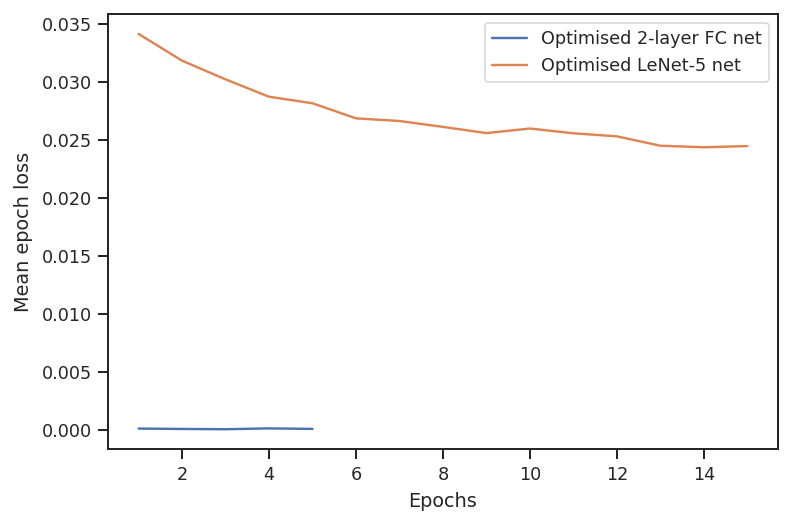

In [ ]:
# Show the learning curves

plt.plot(range(1, len(epoch_losses_2l) + 1), epoch_losses_2l, label='Optimised 2-layer FC net')
plt.plot(range(1, len(epoch_losses_conv) + 1), epoch_losses_conv, label='Optimised LeNet-5 net')
plt.xlabel('Epochs')
plt.ylabel('Mean epoch loss')
plt.legend()

## Session 2:  Finetuning the ConvNet


### STL-10 DATASET

> The provided network is trained on a different dataset named CIFAR-10 4 , which
contains the images of 10 different object categories, each of which has 32 ∗ 32 ∗ 3
dimensions. The dataset we use throughout the assignment is a subset of STL-10 5
with larger sizes and different object classes. So, there is a discrepancy between the
dataset we use to train (CIFAR-10) and test (STL-10) our network. One solution
would be to train the whole network from scratch. However, the number of param-
eters are too large to be trained properly with such few number of images provided.
One solution is to shift the learned weights in a way to perform well on the test
set, while preserving as much information as necessary from the training class.

In this Session, extract 5 classes from STL training dataset , 
the the label of images can be defined as `{1: 'airplanes',2:'birds',3:'ships',4:'cats',5:'dogs'}`

**UPDATE: The above matchups are plain wrong. See corrections below.**

#### *`Q3.1 create the STL10_Dataset `*

In [ ]:
from torch.utils.data import Dataset
from torchvision.datasets.utils import download_and_extract_archive, verify_str_arg
import os

STL_CLASSES = {0 : 'plane', 1 : 'bird', 2 : 'car', 3 : 'cat', 4 : 'deer'}

class STL10_Dataset(Dataset):

    def __init__(self, root='./data', train=True, download=False, transform=None):
        
        # Initialise
        # super(STL10_Dataset, self).__init__(root=root, transform=transform)

        self.base = "stl10_binary"
        self.url  = "http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz"

        self.root = root
        self.train = train
        self.data = []
        self.labels = []
        self.transform = transform

        # Download
        if download:
            download_and_extract_archive(self.url, self.root, filename="stl10_binary.tar.gz")

        # Load data and labels from files
        if self.train:
            xbin, ybin = 'train_X.bin', 'train_y.bin'
        else:
            xbin, ybin = 'test_X.bin', 'test_y.bin'

        # Read and reshape image data
        path_to_data = os.path.join(self.root, self.base, xbin)
        with open(path_to_data, 'rb') as f:
            everything = np.fromfile(f, dtype=np.uint8)
            images = np.reshape(everything, (-1, 3, 96, 96))
            images = np.transpose(images, (0, 1, 3, 2))
        self.data = images

        # Read labels
        labels = None
        path_to_labels = os.path.join(self.root, self.base, ybin)
        with open(path_to_labels, 'rb') as f:
            labels = np.fromfile(f, dtype=np.uint8) - 1
        self.labels = labels

        # Now prune all but the first 5 labels
        print(self.data.shape, self.labels.shape)
        print("Ditching labels above 4...")

        self.data = self.data[self.labels < 5]
        self.labels = self.labels[self.labels < 5]

        print(self.data.shape, self.labels.shape)
 

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, item):

        img = self.data[item]
        target = int(self.labels[item])

        # Convert to a PIL Image
        img = Image.fromarray(np.transpose(img, (1, 2, 0)))

        # Transform (if applicable)
        if self.transform is not None:
            img = self.transform(img)

        return img, target


In [ ]:
# First, let's initialise our dataloaders and transforms

# We want to rescale and normalise the images
stl10_transform=transforms.Compose([
                    transforms.Resize((32, 32)), # Scale to 32x32
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                    ])

# Use our custom dataset with the dataloader
stltrainset = STL10_Dataset(root='./data', train=True, download=True, transform=stl10_transform)
stltrainloader = torch.utils.data.DataLoader(stltrainset, batch_size=4, shuffle=True, num_workers=2)
stltestset = STL10_Dataset(root='./data', train=False, download=False, transform=stl10_transform)
stltestloader = torch.utils.data.DataLoader(stltestset, batch_size=4, shuffle=False, num_workers=2)

Using downloaded and verified file: ./data/stl10_binary.tar.gz
Extracting ./data/stl10_binary.tar.gz to ./data
(5000, 3, 96, 96) (5000,)
Ditching labels above 4...
(2500, 3, 96, 96) (2500,)
(8000, 3, 96, 96) (8000,)
Ditching labels above 4...
(4000, 3, 96, 96) (4000,)


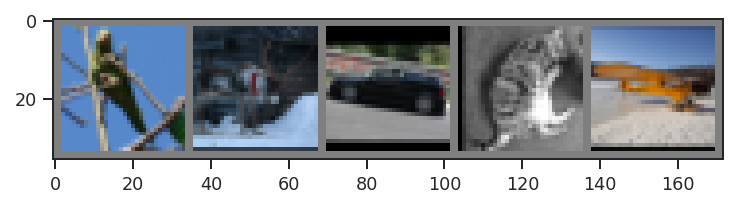

['bird', 'deer', 'car', 'cat', 'plane']


In [ ]:
# This code ensures we get at least one example of each class

sample_images = []
outstanding_labels = [c for c in STL_CLASSES.values()]
labels_ordered = []

for step, (images, labels) in enumerate(stltrainloader):
    if len(outstanding_labels) == 0 or step > 100:
        break
    for image, label in zip(images, labels):
        _label = STL_CLASSES[label.item()]
        if _label in outstanding_labels:
            sample_images.append(image)
            outstanding_labels.remove(_label)
            labels_ordered.append(_label)

imshow(torchvision.utils.make_grid(sample_images, nrow=5))
print(labels_ordered)

#### *`Q3.2  Finetuning from ConvNet & train the model and show the results`*

In [ ]:
from copy import deepcopy

# Copy the trained conv net
stlconv = deepcopy(convnet)

# Modify the output layer to have only 5 nodes
stlconv.o = nn.Linear(84, 5)
stlconv = stlconv.to(device)

summary(stlconv, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 5]             425
Total params: 61,581
Trainable params: 61,581
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.23
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [ ]:
# Fine-tune our already-trained convnet (LeNet-5)
optimizer = optim.SGD(stlconv.parameters(), lr=0.0005, momentum=0.8)
running_losses_stl, epoch_losses_stl = train(stlconv, stltrainloader, optimiser=optimizer, epochs=20)

Training <class '__main__.ConvNet'> on cuda:0 for 20 epochs on 625 minibatches...


1|0/625	Running loss: 1.5792927742004395
1|62/625	Running loss: 95.89911353588104
1|124/625	Running loss: 83.65912365913391
1|186/625	Running loss: 76.08046853542328
1|248/625	Running loss: 67.90835827589035
1|310/625	Running loss: 65.07729083299637
1|372/625	Running loss: 62.17896515130997
1|434/625	Running loss: 62.94506484270096
1|496/625	Running loss: 62.762362599372864
1|558/625	Running loss: 59.5774467587471
1|620/625	Running loss: 60.511460185050964

2|0/625	Running loss: 0.8552860021591187
2|62/625	Running loss: 53.84961020946503
2|124/625	Running loss: 56.449831157922745
2|186/625	Running loss: 50.429144740104675
2|248/625	Running loss: 58.35488221049309
2|310/625	Running loss: 50.59140503406525
2|372/625	Running loss: 54.603146493434906
2|434/625	Running loss: 51.754952758550644
2|496/625	Running loss: 57.07515251636505
2|558/625	Running loss: 52.10463221371174
2|620/625	Running loss: 52.65236

In [ ]:
# Quantify accuracy of network on test set
print("Finetuned ConvNet on STL-5:")
print("Accuracy:", valid(stlconv, stltestloader))
valid_class(stlconv, stltestloader, STL_CLASSES)

Finetuned ConvNet on STL-5:
Accuracy: 0.6815
Accuracy of plane : 83 %
Accuracy of  bird : 50 %
Accuracy of   car : 84 %
Accuracy of   cat : 57 %
Accuracy of  deer : 64 %


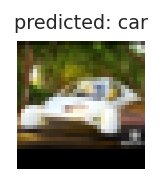

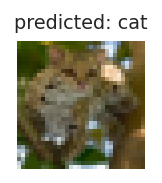

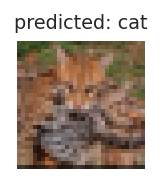

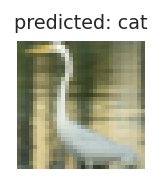

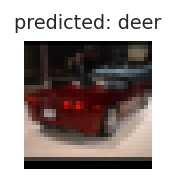

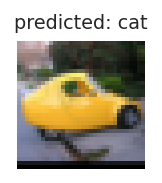

In [ ]:
visualize_model(stlconv, torch.utils.data.DataLoader(stltestset, batch_size=1, shuffle=True, num_workers=1), STL_CLASSES)

#### *`Q3.3  Feature Space Visualization`*

Once the network is trained, it is a good practice to understand the feature space by visualization techniques. There are several techniques to visualize the feature space. In this part, you are expected to use t-sne, which is a dimensionality reduction method. t-sne takes as input features and labels, then reduces their dimensions to 2, where the structure of the feature and label space is preserved as much as possible.

In [ ]:
from sklearn.manifold import TSNE
from copy import deepcopy

def visualise_tsne(X, targets, label_names):
    fig = plt.figure(figsize=(7,7))
    _X = deepcopy(X)
    X_embedded = TSNE(n_components=2).fit_transform(_X)
    print(_X.shape, '->', X_embedded.shape)
    for i in range(5):
        _X = X_embedded[targets == i, :]
        plt.scatter(_X[:,0], _X[:,1], label=label_names[i])
    plt.legend()

In [ ]:
def predict_with_labels(net, dataloader):
    """Generates the output layer of a trained neural net along with true labels
    """

    outputs, labels = [], []
    with torch.no_grad():
        for data in dataloader:
            imgs, labs = data
            imgs, labs = imgs.to(device), labs.to(device)
            outputs.append(net(imgs).cpu())
            labels.extend([l for l in labs.cpu().numpy()])

    outputs = np.vstack(outputs)
    labels = np.array(labels)
    print(outputs.shape)
    print(labels.shape)
    return outputs, labels

(2500, 10)
(2500,)
(2500, 10) -> (2500, 2)


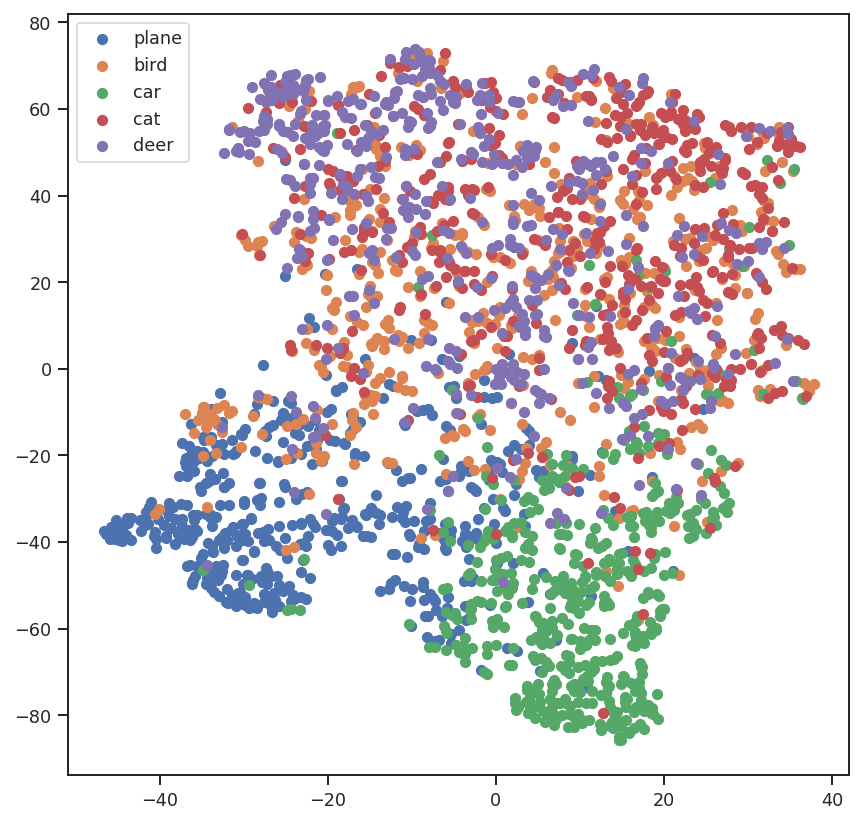

In [ ]:
# Training data on pre-trained convnet
out, lab = predict_with_labels(convnet, stltrainloader)
visualise_tsne(out, lab, STL_CLASSES)

(4000, 10)
(4000,)
(4000, 10) -> (4000, 2)


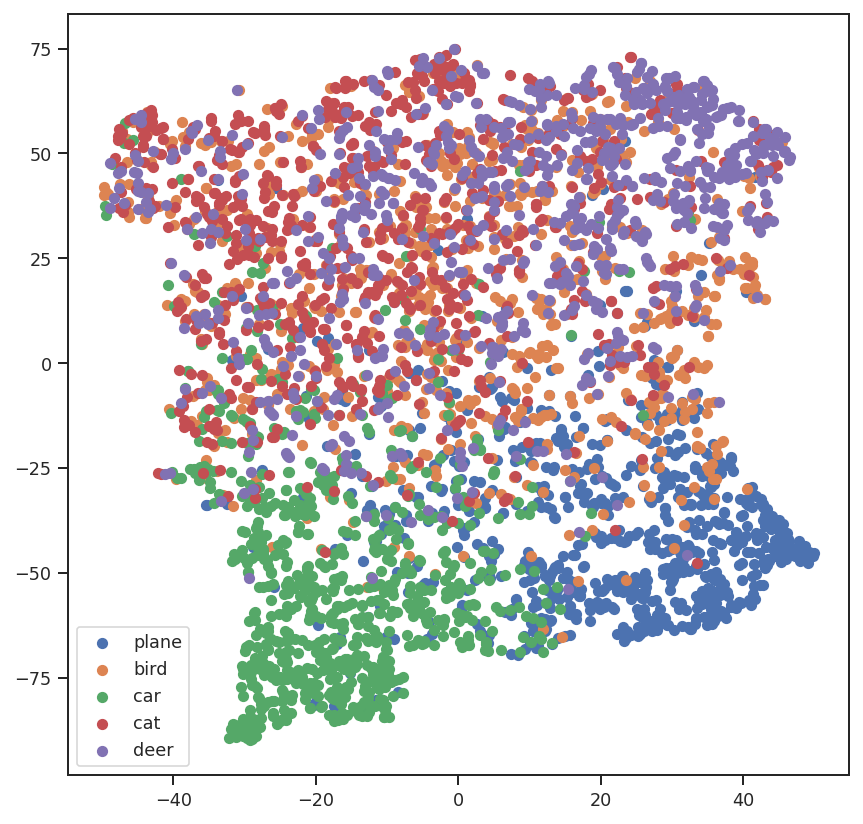

In [ ]:
# Testing data on pre-trained convnet
out, lab = predict_with_labels(convnet, stltestloader)
visualise_tsne(out, lab, STL_CLASSES)

(2500, 5)
(2500,)
(2500, 5) -> (2500, 2)


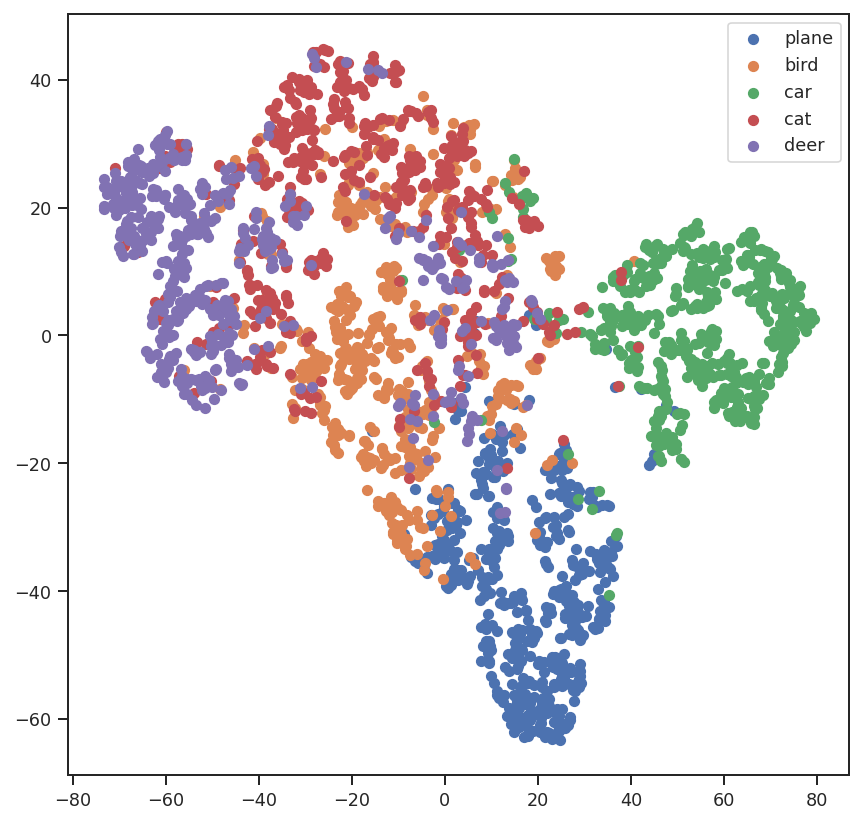

In [ ]:
# Training data on fine-tuned convnet
out, lab = predict_with_labels(stlconv, stltrainloader)
visualise_tsne(out, lab, STL_CLASSES)

(4000, 5)
(4000,)
(4000, 5) -> (4000, 2)


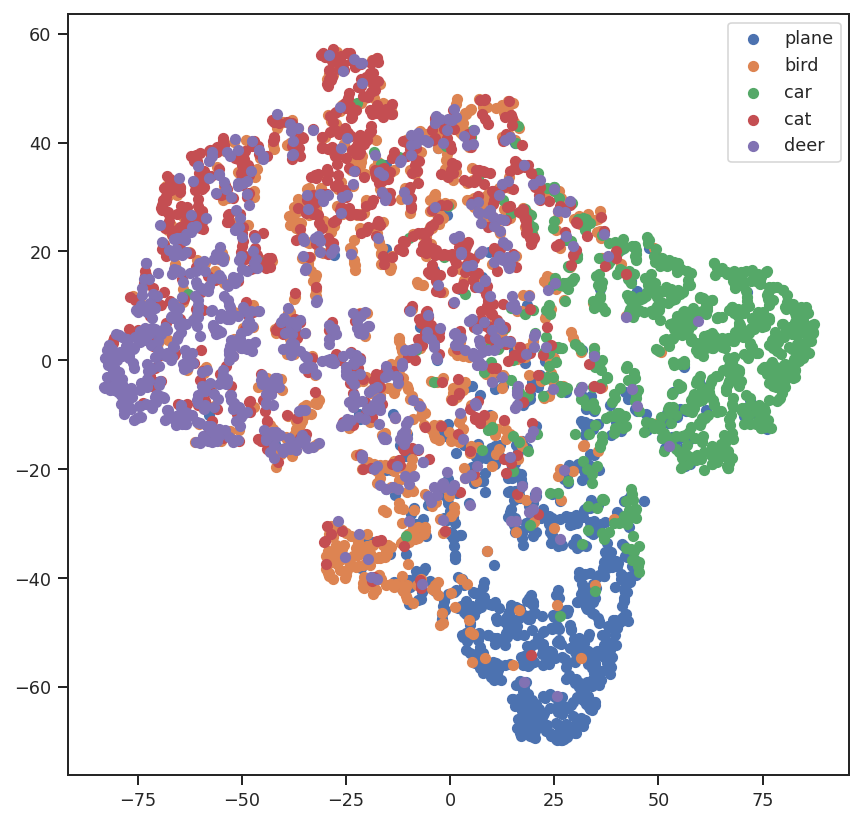

In [ ]:
# Testing data on fine-tuned convnet
out, lab = predict_with_labels(stlconv, stltestloader)
visualise_tsne(out, lab, STL_CLASSES)